# Setup - defining parameters

In [28]:

#thresholds for spot detection (*std)
sigmaFind=50     #sigma of threshold for finding spots
sigmaCent=15     #sigma of threshold for calculating moments

#paramters for finding threshiood

sigmaThresh = 4
threshFact = 2

#other spot detection parameters - probably won't need to change
boxFind=10    #size of box for finding spots
boxCent=6     #size of box for centroiding
nmin=10       #minimum number of acceptable pixels in a spot
nmax=90       #maximum number of acceptable pixels in a spot
maxIt=20      #maximum number of iterations for centroiding

#set to non zero to override automatic fwhm determination. 
fwhmx=0
fwhmy=0

#inter = 1 for notebook, 0 for scripts, cenFlag='local' for local, 'db' to read from database
inter=1
cenFlag='local'
#cenFlag='db'

#dataSource - set to 'pinhole' for pinhole mask, 'taichung' for lab data. 

dataType='pinhole'

#conifguration for rotator center

config="oct18"

#database info - update as needed
user='pfs'
passwd='fps'
host='133.40.164.208'
dbname='pfspass'
conn=None


# Setup - importing

In [3]:
%matplotlib notebook

import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import sigmaclip
import sys

#kludge - need to change???
sys.path.append("/Users/karr/Science/PFS/NewCode/Code/pfs_utils/python/pfs/utils/coordinates/")
import CoordTransp
import DistortionCoefficients
from importlib import reload  #for debugging purposes

#the try/except is for using in the MHS environment, or standalone. 

try:
    import mcsActor.Visualization.mcsRoutines as mcs
except:
    import mcsRoutines as mcs

try:
    import mcsActor.Visualization.fpsRoutines as fps
except:
    import fpsRoutines as fps

try:
    import mcsActor.Visualization.visRoutines as vis
except:
    import visRoutines as vis

try:
    import mcsActor.Visualization.vis_plot as visplot
except:
    import vis_plot as visplot




# connect to database (not done in calib mode)

In [3]:

reload(vis)
#connect to database if in DB mode
if(cenFlag=='db'):
    conn=vis.dbConnect(user=user,dbname=dbname,passwd=pfspass,host=host)
    
#read instrument parameters if available
if(config != "calib"):
    rotCent,offset=vis.loadInstParams(config)


# parameters that change for each run

In [25]:

#set frame ID minimum and maximum values (inclusive)

frameID=14651

#source directory data files in local mode
sourceDir="/Users/karr/ics_mcsActor/python/mcsActor/Visualization/Day3/"
fPref="PFSC"

#subtitle for plots - currently set to first frame ID plus tag
stitle=""

moveID=0
#get list of file names
fname,prefix=vis.getFileName(frameID,moveID,sourceDir,fPref,dataType='pinhole')


## expected get positions of cobras (not during calib)

In [47]:
reload(fps)
reload(vis)
#get instrument parameters
rotCent,offset=vis.loadInstParams('aug19')
#get spot positions in PFI mm
fiducials,scienceFibres=fps.getFieldDefinition('')
#transform
fibrePos=fps.getFibrePos(fiducials,scienceFibres,0,0,rotCent,offset)

print(rotCent,offset)

[4470, 2873] [0, -85]


Scaling


# calculate threshold values and region (once per config)

Thresholds= 3733.5448676986834 2664.296757866315
Boundaries of region (x1,x2,y1,y2):  18 3859 2515 6447


<IPython.core.display.Javascript object>


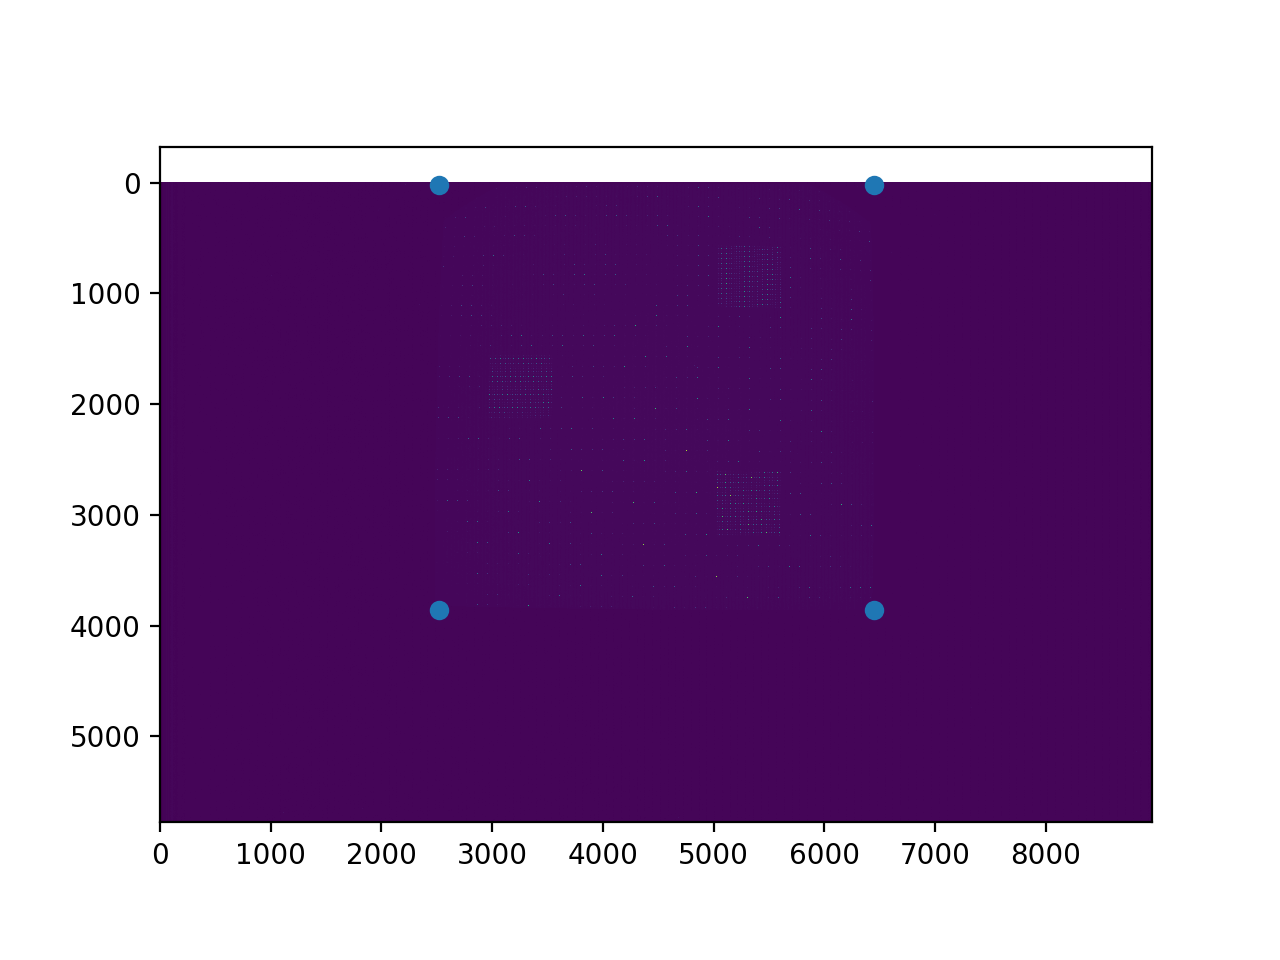

In [29]:
#not needed if pulling from DB
reload(vis)
reload(fps)
reload(mcs)
config='calib'

if((cenFlag=='local')):
    
    image=vis.getImage(fname)

    #if config is not known, find the region (must be rotate by multiple of 90 degrees)
    if(config=='calib'):
        findThresh,centThresh,xrange,yrange=mcs.getThresh(image,'calib',sigmaThresh,threshFact,sigmaFind,sigmaCent)
    #if config is known, calculate the region for the threshold from the coord transforms
    else:
        findThresh,centThresh,xrange,yrange=mcs.getThresh(image,'fieldID',sigmaThresh,threshFact,sigmaFind,sigmaCent,fibrePos=fibrePos)

print("Thresholds=",findThresh,centThresh)
print("Boundaries of region (x1,x2,y1,y2): ",xrange[0],xrange[1],yrange[0],yrange[1])
visplot.checkThreshold(image,xrange,yrange)

#yrange[0]=2786
#a=mcs.getManualThresh(image,xrange,yrange,sigmaThresh)
#findThresh=a.mean()+a.std()*sigmaFind
#centThresh=a.mean()+a.std()*sigmaCent


# Do the centroiding for a set of database, either locally or retrieve from DB


<IPython.core.display.Javascript object>


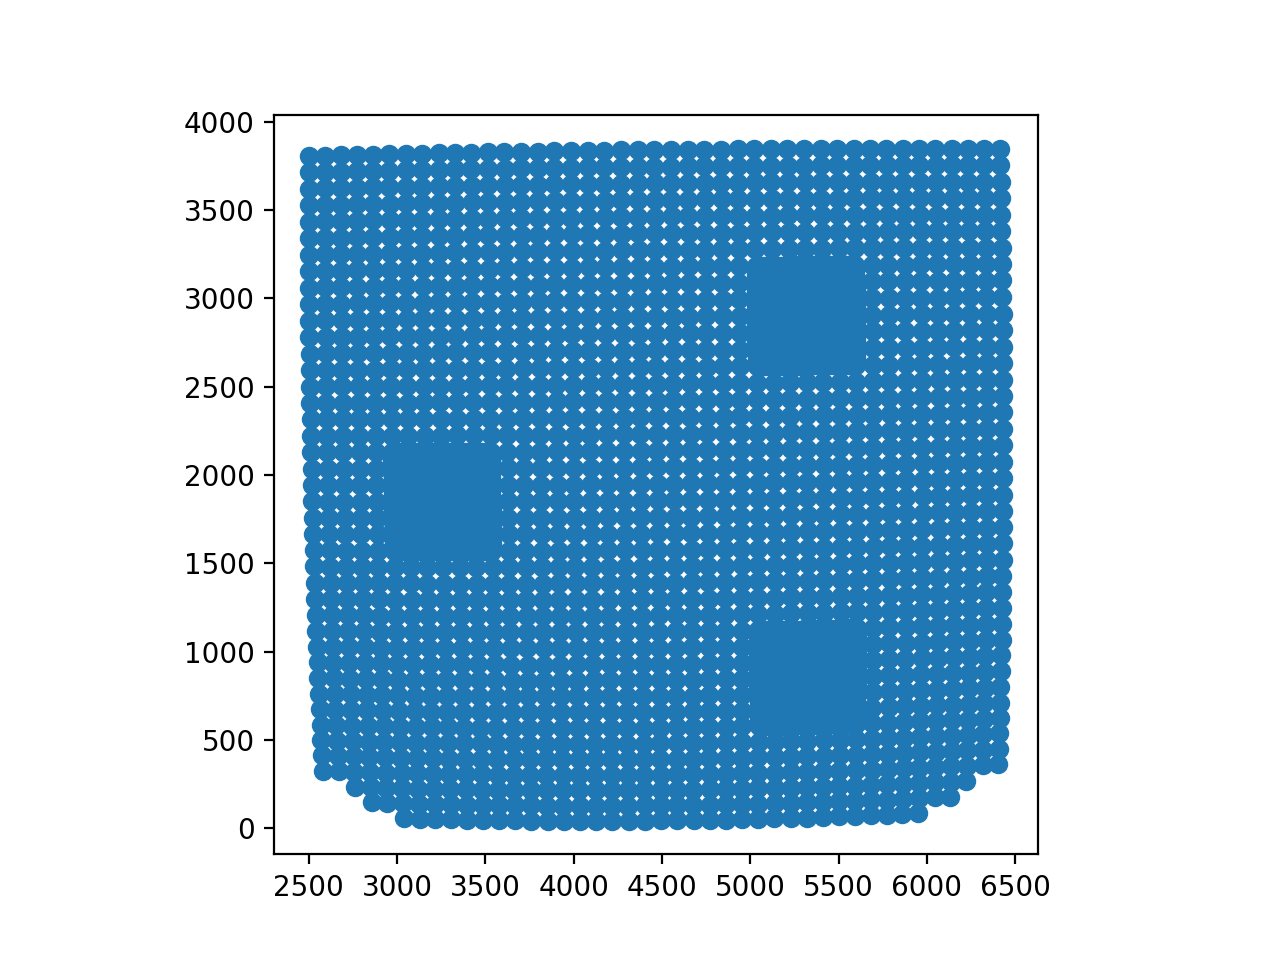

In [31]:
reload(vis)
reload(visplot)

redo=1 #flag to calculate the centroids

#local case - either read files and calculate, or load data from a file. 
if(cenFlag=="local"):
    centroids=vis.getCentroids(image,findThresh*0.8,centThresh,fwhmx,fwhmy,boxFind,boxCent,nmin,nmax,maxIt)

#db case - read from database
elif(cenFlag=='db'):
    printf("Loading Centroids from DB.")
    centroids=vis.getCentroidsDB(conn,frameID)        

#some assignments, for easier plotting
x=centroids[:,1]
y=centroids[:,2]
fx=centroids[:,3]    
fy=centroids[:,4]
peak=centroids[:,5]
back=centroids[:,6]
    
#plot the centroids for a quick check
visplot.checkCentroids(x,y,1,prefix,inter)


## Match points to expected positions

In [50]:
reload(mcs)
reload(fps)

#match all the frames to the first frame
tol=50
mCentroid=mcs.findHomes(centroids,fibrePos,tol)
dx,dy = fps.getDiff(mCentroid,fibrePos)



# Image Quality Plots

Now we get into the analysis part. 

Plots of FWHM values, peak values. Change "plotRange" to adjust the range. 


<IPython.core.display.Javascript object>


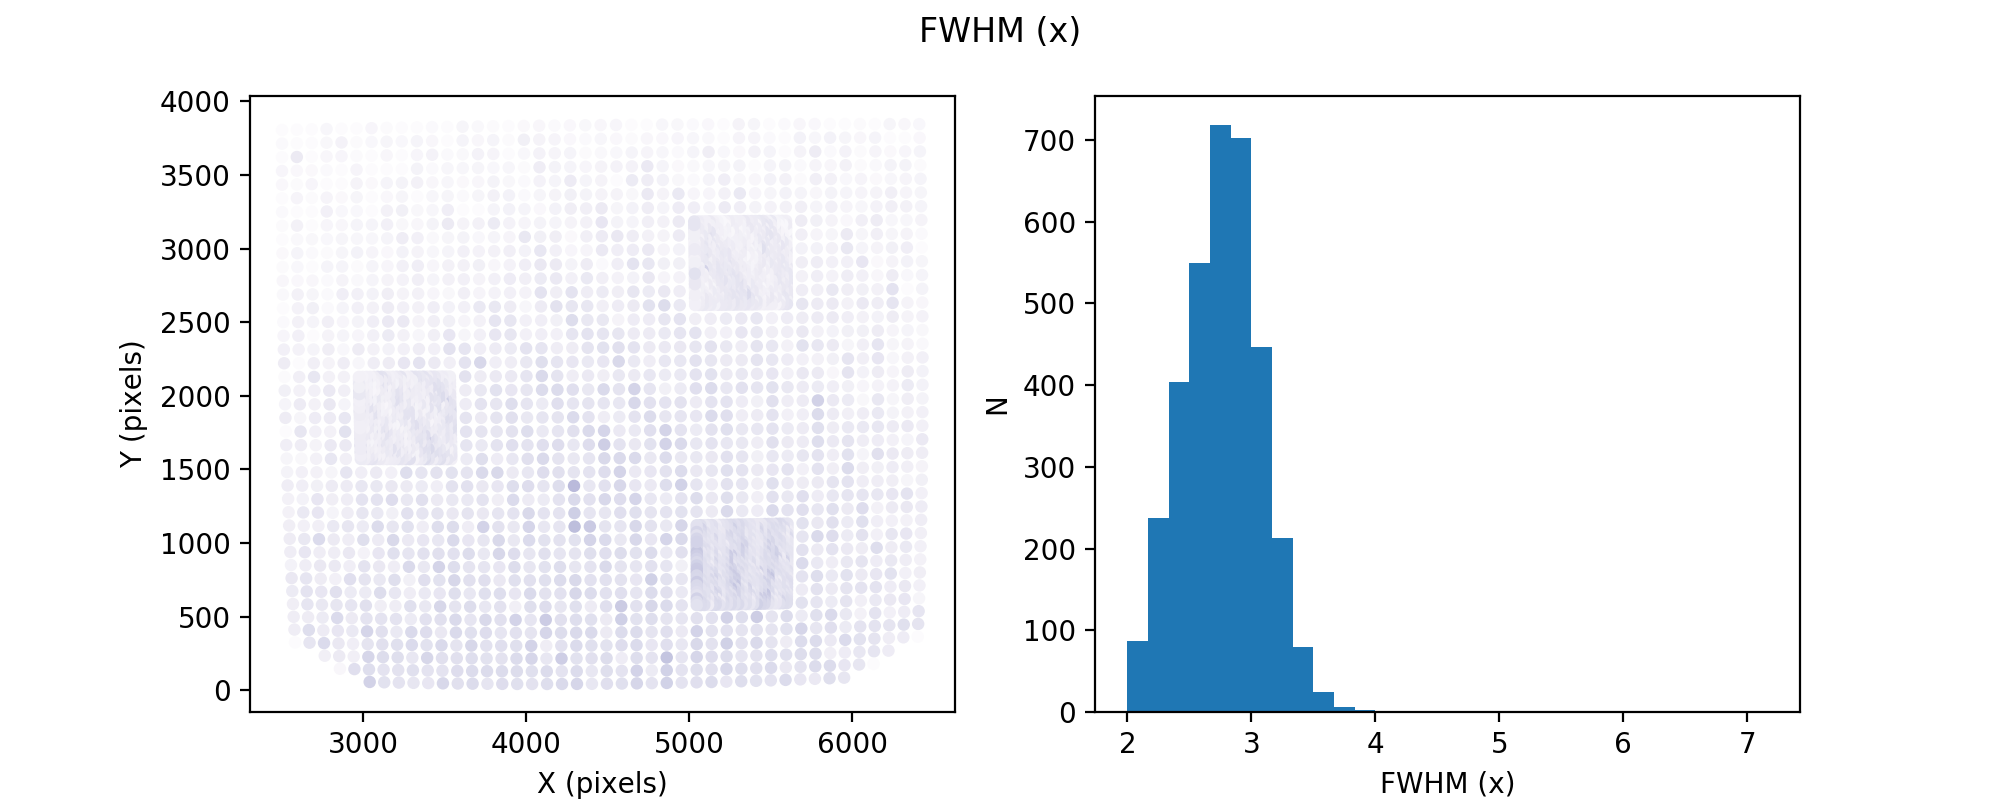

here
here1


<IPython.core.display.Javascript object>


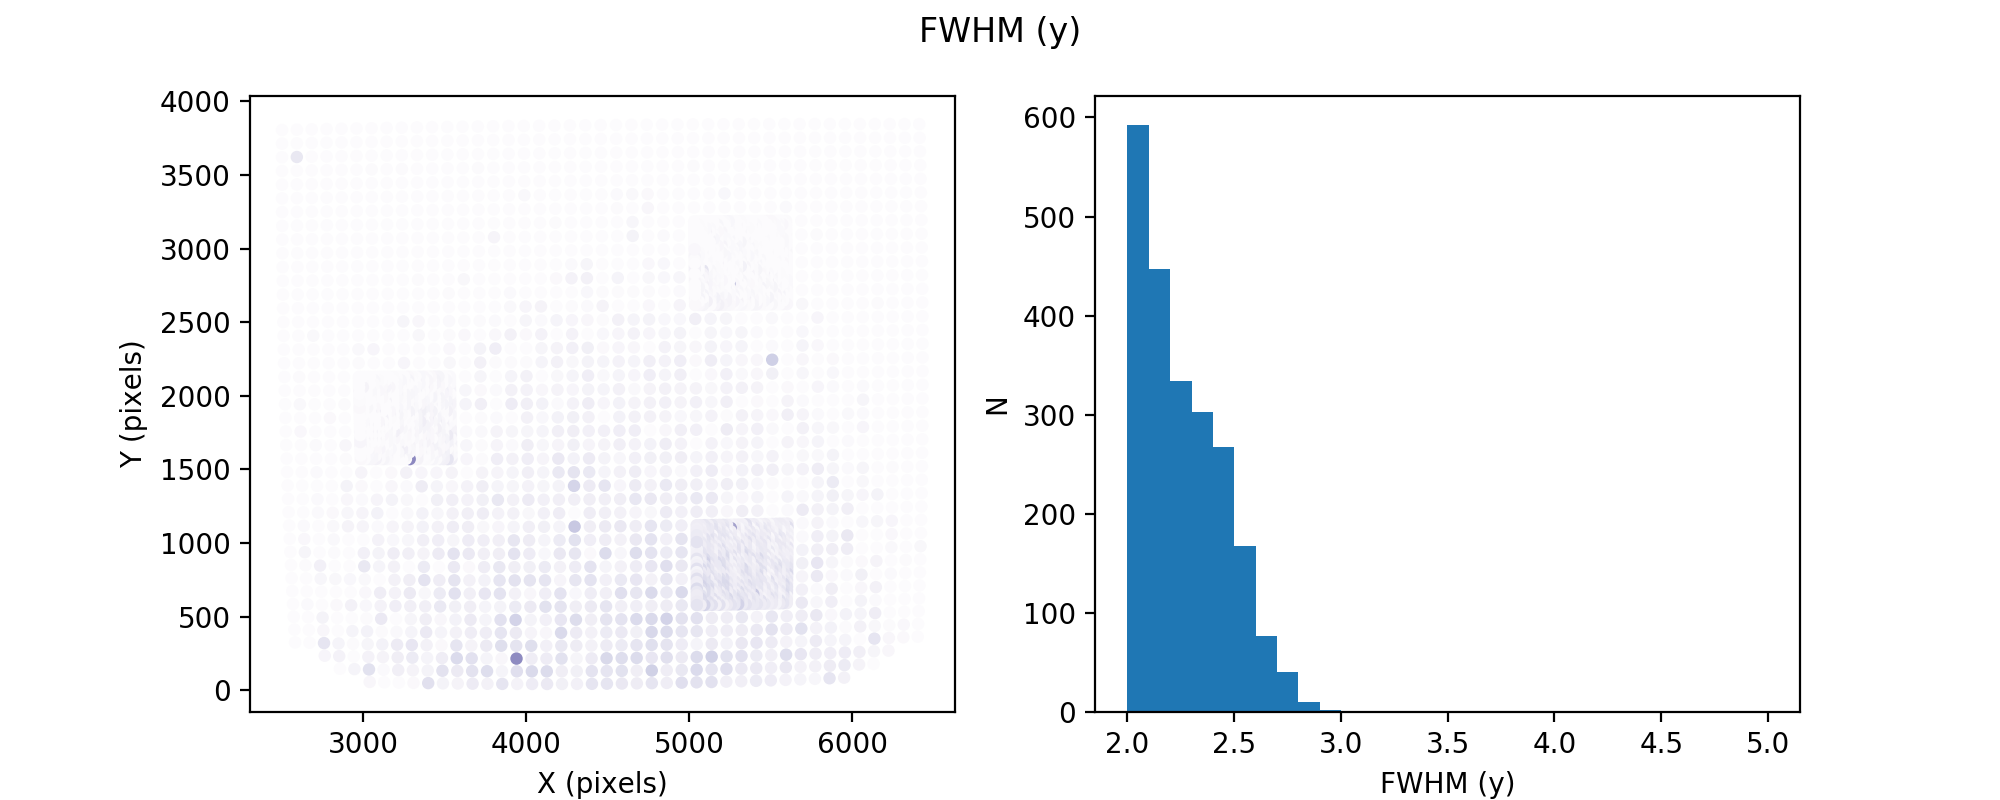

here
here1


<IPython.core.display.Javascript object>


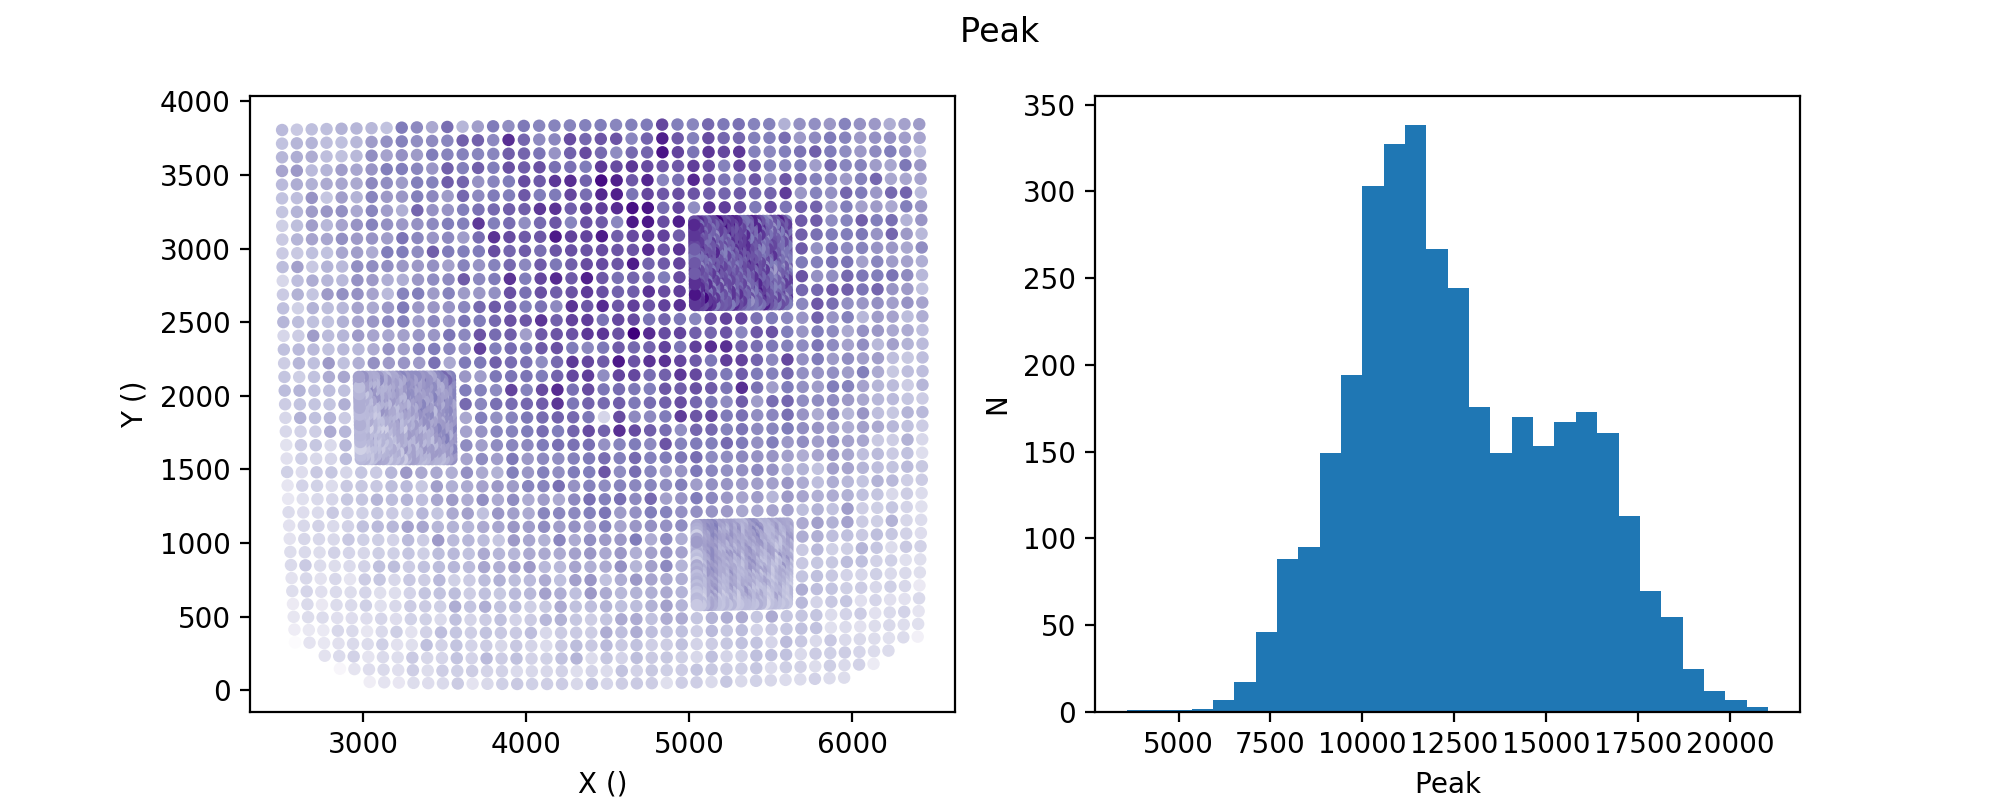

here
here1


In [33]:
reload(visplot)

plotRange=None
nbins=30

plotRange=[2,7]
visplot.pairPlot(x,y,fx,fx,plotRange,"FWHM (x)",prefix,"_fwhmx","FWHM (x)","pixels",nbins,inter,stitle=stitle)
plotRange=[2,5]
visplot.pairPlot(x,y,fy,fy,plotRange,"FWHM (y)",prefix,"_fwhmy","FWHM (y)","pixels",nbins,inter,stitle=stitle)
plotRange=[peak.min(),peak.max()]
visplot.pairPlot(x,y,peak,peak,plotRange,"Peak",prefix,"_peak","Peak","",nbins,inter,stitle=stitle)


# Distortion Plots

Calculations and plots for distortion of a single field. The results are plotted in three forms; quiver, colour map in mm units, colour map in units of % of the field size. 


<IPython.core.display.Javascript object>


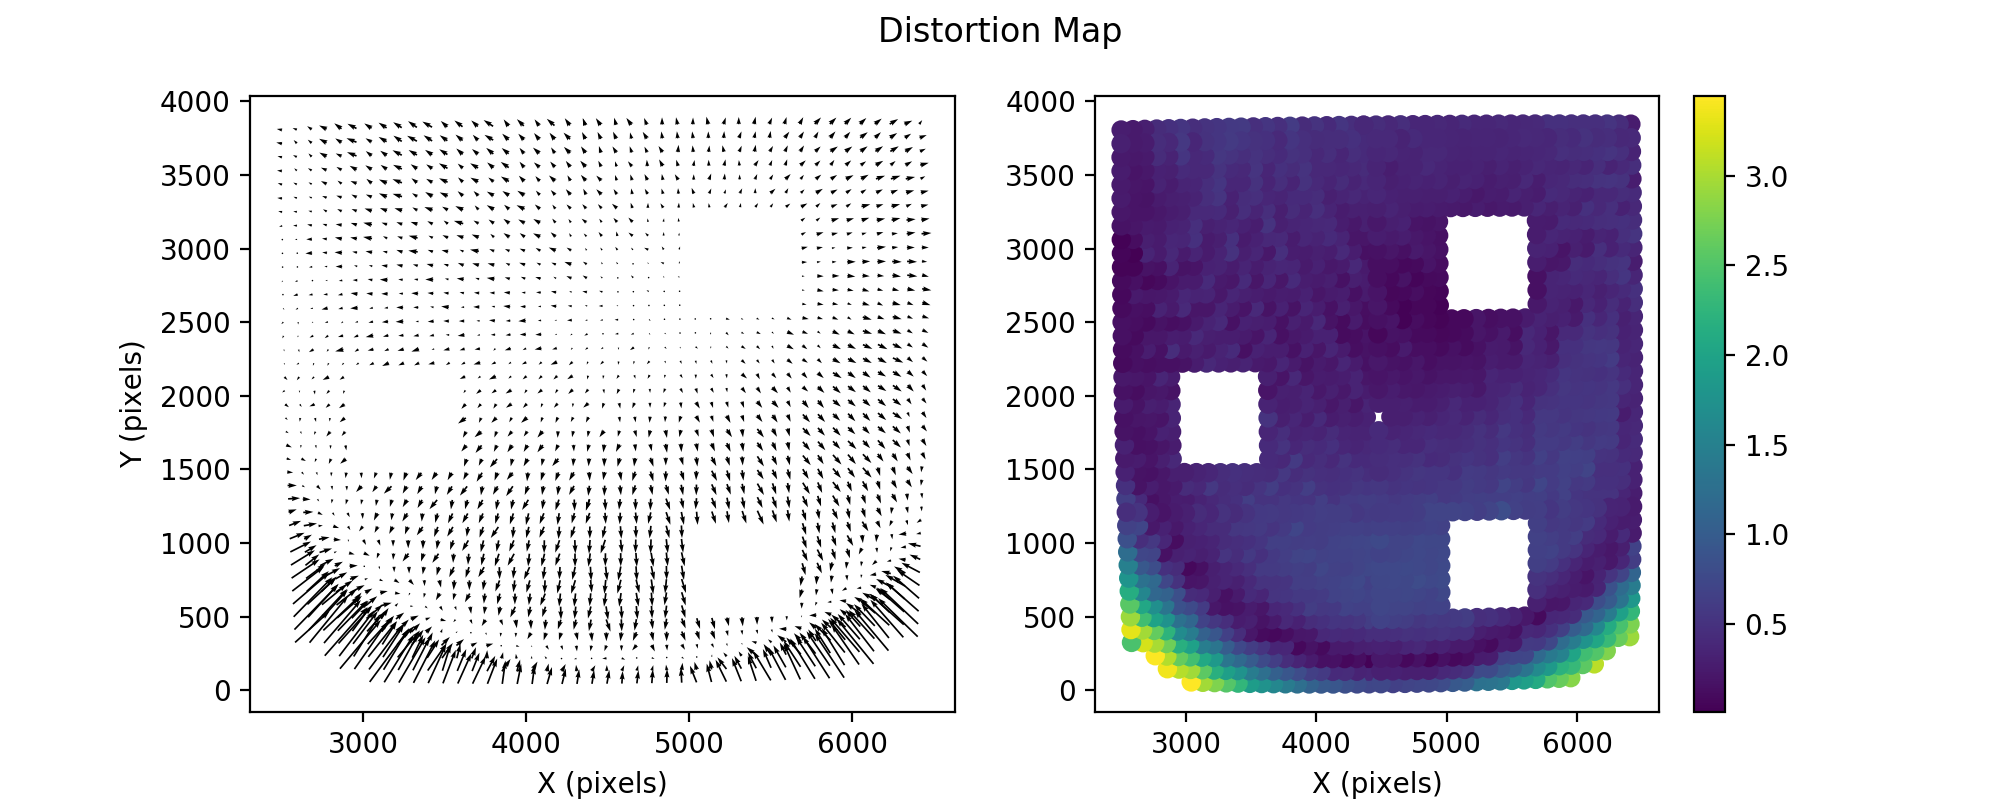

(1703,) (1703,) (1703,) (1703,)


In [70]:
reload(visplot)
visplot.quiverPlot(mCentroid[:,1],mCentroid[:,2],dx,dy)
print(mCentroid[:,1].shape,mCentroid[:,2].shape,dx.shape,dy.shape)


In [71]:
abs(dx).min(),abs(dx).max(),abs(dy).min(),abs(dy).max()


(0.00048199575485341484,
 2.3061001192349977,
 0.00021839926466782345,
 2.767802634067337)

<IPython.core.display.Javascript object>


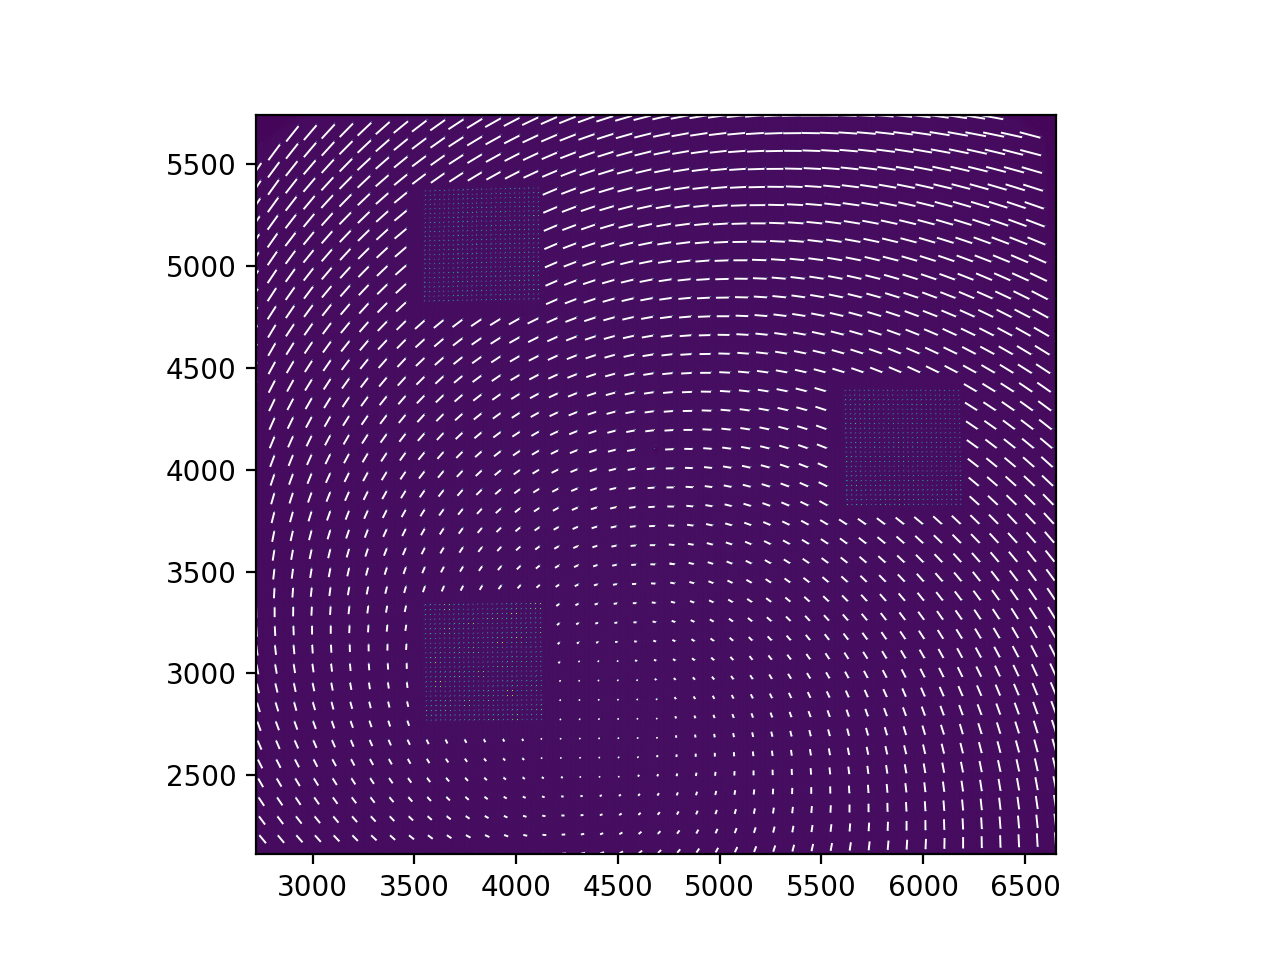

2721.6593826463627 6652.615660817817 2111.0373771076647 5741.865508870483


In [105]:
reload(visplot)
visplot.diagPlot(image,mCentroids,dx,dy)


<IPython.core.display.Javascript object>


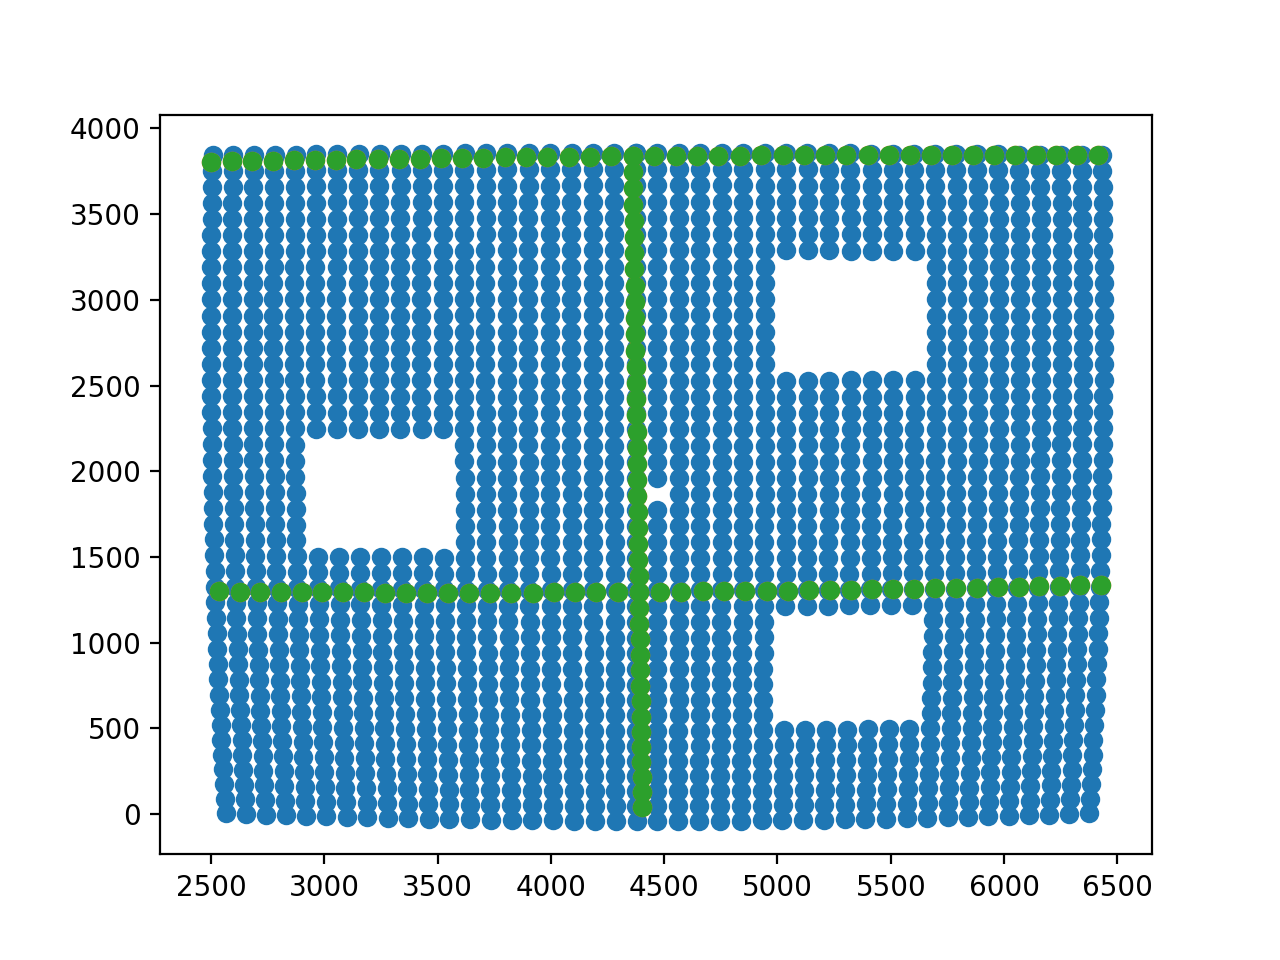

In [75]:



fig,ax=plt.subplots()
ax.scatter(fibrePos[:,1],fibrePos[:,2])
ax.scatter(mCentroid[0:129,1],mCentroid[0:129,2])
ax.scatter(mCentroid[0:129,1],mCentroid[0:129,2])
fig.show()

<IPython.core.display.Javascript object>


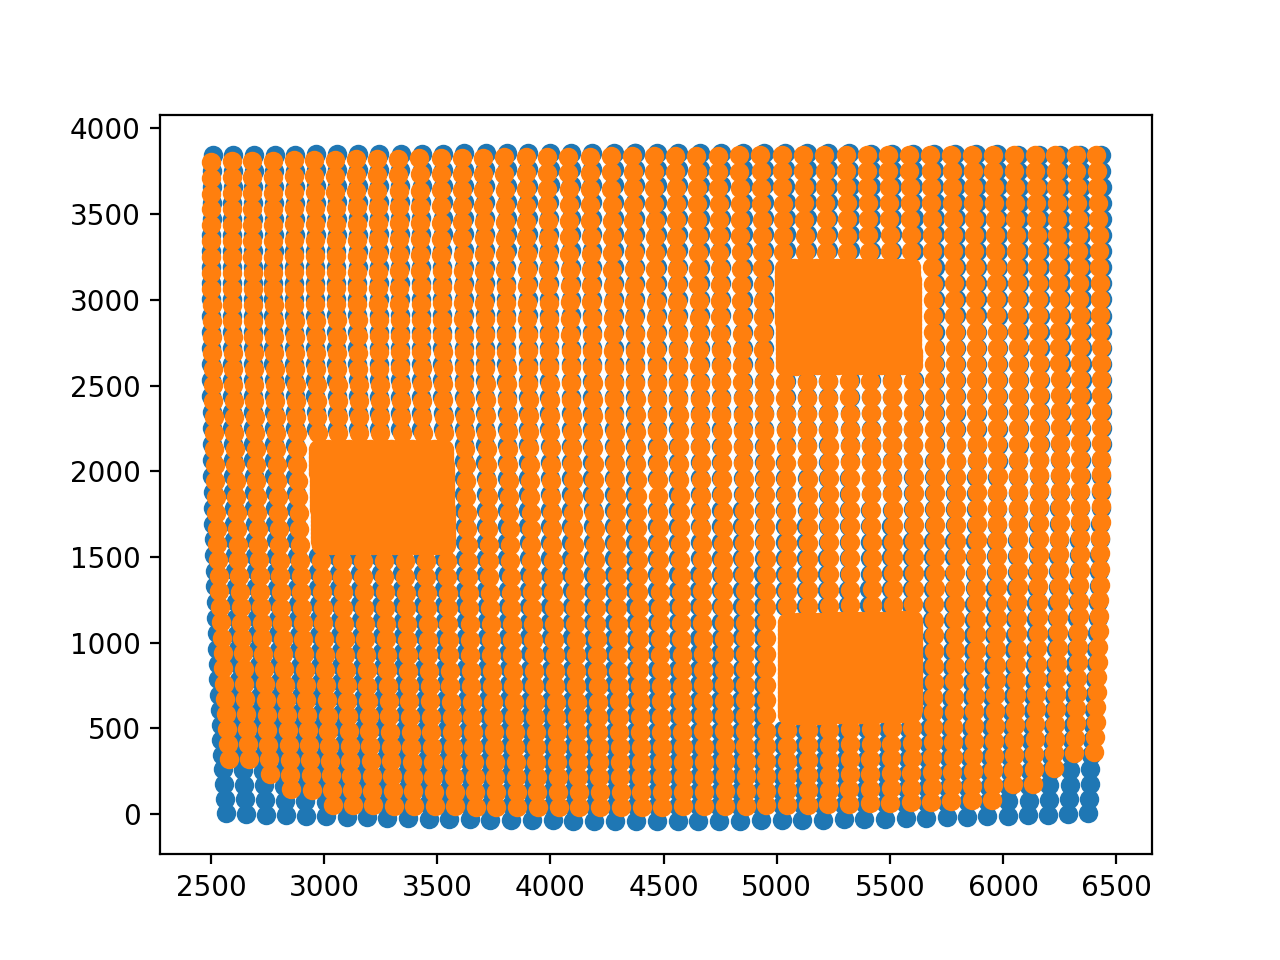

In [48]:
fig,ax=plt.subplots()
ax.scatter(fibrePos[:,1],fibrePos[:,2])
ax.scatter(x,y)

In [68]:

transform,xd,yd,sx,sy,rotation=vis.getTransform(fibrePos[:,1],fibrePos[:,2],mCentroid[:,1],mCentroid[:,2],1)
xf,yf=vis.transformPointsNew(fibrePos[:,1],fibrePos[:,2],xd,yd,rotation,sx,sy)
dx,dy = fps.getDiff(mCentroid,np.array([xf,xf,yf]).T)


masked_array(data=[0.15709586079083238, 0.4112860994637231,
                   0.44823031550822634, ..., -0.2066045181386471,
                   -0.16869731142332967, -0.3048795151694321],
             mask=[False, False, False, ..., False, False, False],
       fill_value=1e+20)

In [72]:
xd,yd,rotation,sx,sy

(41.422886387068274,
 -49.09613048635294,
 0.010105705281217929,
 0.9964726126513141,
 0.9964726126513141)